<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# How to rediscover the Higgs boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

ATLAS Open Data provides open access to proton-proton collision data at the LHC for educational purposes. ATLAS Open Data resources are ideal for high-school, undergraduate and postgraduate students.

Notebooks are web applications that allow you to create and share documents that can contain for example:
1. live code
2. visualisations
3. narrative text

This analysis loosely follows the discovery of the Higgs boson by ATLAS https://arxiv.org/pdf/1207.7214.pdf (mostly Section 5 and 5.1)

By the end of this notebook you will be able to:
1. rediscover the Higgs boson yourself!
2. know some general principles of a particle physics analysis

Feynman diagram pictures are borrowed from our friends at https://www.particlezoo.net

<CENTER><img src="images/feynman_diagrams/Hyy_feynman.png" style="width:40%"></CENTER>

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[First time setup on your computer (no need on mybinder)](#setup_computer) <br />
[To setup everytime](#setup_everytime) <br />
[Lumi, fraction, file path](#fraction) <br />
[Samples](#samples) <br />
[Changing a cut](#changing_cut) <br />
[Applying a cut](#applying_cut) <br />
[Plotting](#plotting) <br />
[What can you do to explore this analysis?](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by clicking Cell -> Run Cells, or using the keyboard shortcut Shift+Enter.

<a id='setup_computer'></a>

## First time setup on your computer (no need on mybinder)
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close Jupyter and re-open on the same computer, you won't need to run this first cell again.

If you open on binder, you don't need to run this cell.

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib lmfit --user # install required packages

[Back to contents](#contents)

<a id='setup_everytime'></a>

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

We're going to be using a number of tools to help us:
* uproot: lets us read .root files typically used in particle physics into data formats used in python
* pandas: lets us store data as dataframes, a format widely used in python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations
* lmfit: tool for statistical fitting

In [1]:
import uproot3 # for reading .root files
import pandas as pd # to store data as dataframe
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits

[Back to contents](#contents)

<a id='fraction'></a>

## Lumi, fraction, file path

General definitions of luminosity, fraction of data used, where to access the input files

In [2]:
lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
#lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 0.8 # reduce this is you want the code to run quicker

#tuple_path = "Input/GamGam/Data/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/" # web address

<a id='samples'></a>

## Samples

Samples to process

In [3]:
samples_list = ['data_A'] #'data_B','data_C','data_D' # add if you want more data


[Back to contents](#contents)

Define function to get data from files

The datasets used in this notebook have already been filtered to include at least 2 photons per event, so that processing is quicker.

In [4]:
def get_data_from_files():

    frames = [] # define empty list to hold data
    for val in samples_list: # loop over each file
        fileString = tuple_path+val+".GamGam.root" # file name to open
        temp = read_file(fileString,val) # call the function read_file defined below
        frames.append(temp) # append dataframe returned from read_file to list of dataframes
    data = pd.concat(frames) # concatenate list of dataframes together into one dataframe
    
    return data # return dataframe

Define function to calculate diphoton invariant mass

In [5]:
def calc_myy(photon_pt,photon_eta,photon_phi,photon_E):
    # first photon is [0], 2nd photon is [1] etc
    px_0 = photon_pt[0]*math.cos(photon_phi[0]) # x-component of photon[0] momentum
    py_0 = photon_pt[0]*math.sin(photon_phi[0]) # y-component of photon[0] momentum
    pz_0 = photon_pt[0]*math.sinh(photon_eta[0]) # z-component of photon[0] momentum
    px_1 = photon_pt[1]*math.cos(photon_phi[1]) # x-component of photon[1] momentum
    py_1 = photon_pt[1]*math.sin(photon_phi[1]) # y-component of photon[1] momentum
    pz_1 = photon_pt[1]*math.sinh(photon_eta[1]) # z-component of photon[1] momentum
    sumpx = px_0 + px_1 # x-component of diphoton momentum
    sumpy = py_0 + py_1 # y-component of diphoton momentum
    sumpz = pz_0 + pz_1 # z-component of diphoton momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of diphoton momentum 
    sumE = photon_E[0] + photon_E[1] # energy of diphoton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

[Back to contents](#contents)

<a id='changing_cut'></a>

## Changing a cut

If you change a cut: Cell -> Run All Below

If you change a cut here, you also need to make sure the cut is applied in the "[Applying a cut](#applying_cut)" cell.

In [6]:
# Cut on photon reconstruction quality
# paper: "Photon candidates are required to pass identification criteria"
def cut_photon_reconstruction(photon_isTightID):
# isTightID==True means a photon identified as being well reconstructed
# want to keep events where True for both photons
# first photon is [0], 2nd photon is [1] etc
    return photon_isTightID[0]==True and photon_isTightID[1]==True
    
# Cut on Transverse momentum
# paper: "The leading (sub-leading) photon candidate is required to have ET > 40 GeV (30 GeV)"
def cut_photon_pt(photon_pt):
# want to keep events where photon_pt[0]>40000 MeV and photon_pt[1]>30000 MeV
    return photon_pt[0]>40000 and photon_pt[1]>30000

# Cut on energy isolation
# paper: "Photon candidates are required to have an isolation transverse energy of less than 4 GeV"
def cut_isolation_et(photon_etcone20):
# want to keep events where isolation eT<4000 MeV
    return photon_etcone20[0]<4000 and photon_etcone20[1]<4000

# Cut on pseudorapidity in barrel/end-cap transition region
# paper: "excluding the calorimeter barrel/end-cap transition region 1.37 < |η| < 1.52"
def cut_photon_eta_transition(photon_eta):
# want to keep events where modulus of photon_eta is outside the range 1.37 to 1.52
    return (abs(photon_eta[0])>1.52 or abs(photon_eta[0])<1.37) and (abs(photon_eta[1])>1.52 or abs(photon_eta[1])<1.37)


[Back to contents](#contents)

<a id='applying_cut'></a>

## Applying a cut 

If you add a cut: Cell -> Run All Below

In [7]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("Processing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    for data in tree.iterate(["photon_pt","photon_eta","photon_phi","photon_E",
                            "photon_isTightID","photon_etcone20"], # add more variables here if you want to use them
                           outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                           entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
        
        # Cut on photon reconstruction quality using the function cut_photon_reconstruction defined above
        data = data[ np.vectorize(cut_photon_reconstruction)(data.photon_isTightID)]
        
        # Cut on transverse momentum of the photons using the function cut_photon_pt defined above
        data = data[ np.vectorize(cut_photon_pt)(data.photon_pt)]
        
        # Cut on energy isolation using the function cut_isolation_et defined above
        data = data[ np.vectorize(cut_isolation_et)(data.photon_etcone20)]
        
        # Cut on pseudorapidity inside barrel/end-cap transition region using the function cut_photon_eta_transition
        data = data[ np.vectorize(cut_photon_eta_transition)(data.photon_eta)]
        
        # Calculate reconstructed diphoton invariant mass using the function calc_myy defined above
        data['myy'] = np.vectorize(calc_myy)(data.photon_pt,data.photon_eta,data.photon_phi,data.photon_E)
        
        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['photon_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['photon_pt','photon_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        elapsed = time.time() - start # time taken to process
        print("\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

[Back to contents](#contents)

This is where the processing happens (this will take some minutes)

In [8]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing: data_A
	 nIn: 344275,	 nOut: 	17799	 in 202.3s
Time taken: 203.0s


<a id='plotting'></a>

## Plotting
If you only want a make a change in the plot: Cell -> Run All Below

Define function to plot the data.

In [9]:
def plot_data(data):   

    xmin = 100 # GeV
    xmax = 160 # GeV
    step_size = 2 # GeV
    
    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['myy'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    # data fit
    polynomial_mod = PolynomialModel( 4 ) # 4th order polynomial
    gaussian_mod = GaussianModel() # Gaussian
    
    # set initial guesses for the parameters of the polynomial model
    # c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                                x=bin_centres, c0=data_x.max(), c1=0,
                                c2=0, c3=0, c4=0 )
    
    # set initial guesses for the parameters of the Gaussian model
    pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                               x=bin_centres, amplitude=100, 
                               center=125, sigma=2 )
    
    model = polynomial_mod + gaussian_mod # combined model
    
    # fit the model to the data
    out = model.fit(data_x, # data to be fit
                    pars, # guesses for the parameters
                    x=bin_centres, weights=1/data_x_errors ) 

    # background part of fit
    params_dict = out.params.valuesdict() # get the parameters from the fit to data
    c0 = params_dict['c0'] # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c1 = params_dict['c1'] # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c2 = params_dict['c2'] # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c3 = params_dict['c3'] # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c4 = params_dict['c4'] # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    
    # get the background only part of the fit to data
    background = c0 + c1*bin_centres + c2*bin_centres**2 + c3*bin_centres**3 + c4*bin_centres**4

    # data fit - background fit = signal fit
    signal_x = data_x - background 


    # *************
    # Main plot 
    # *************
    plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                       fmt='ko', # 'k' means black and 'o' means circles
                       label='Data' ) 
    
    # plot the signal + background fit
    main_axes.plot(bin_centres, # x
                   out.best_fit, # y
                   '-r', # single red line
                   label='Sig+Bkg Fit ($m_H=125$ GeV)' )
    
    # plot the background only fit
    main_axes.plot(bin_centres, # x
                   background, # y
                   '--r', # dashed red line
                   label='Bkg (4th order polynomial)' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          labelbottom=False, # don't draw tick labels on bottom axis
                          right=True ) # draw ticks on right axis
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV', 
                         horizontalalignment='right') 
    
    # set the y-axis limit for the main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 ) 
    
    # set minor ticks on the y-axis of the main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.2, # x
             0.92, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.2, # x
             0.86, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.2, # x
             0.8, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes 
    
    # Add a label for the analysis carried out
    plt.text(0.2, # x
             0.74, # y
             r'$H \rightarrow \gamma\gamma$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend(frameon=False, # no box around the legend
                     loc='lower left' ) # legend location 


    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes
    
    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles
    
    # draw the fit to data
    sub_axes.plot(bin_centres, # x
                  out.best_fit-background, # y
                  '-r' ) # single red line
    
    # draw the background only fit
    sub_axes.plot(bin_centres, # x
                  background-background, # y
                  '--r' )  # dashed red line
    
    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # x-axis label
    sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 ) 
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis 
    
    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Events-Bkg' ) 


    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes
    
    return

[Back to contents](#contents)

Call the function to plot the data

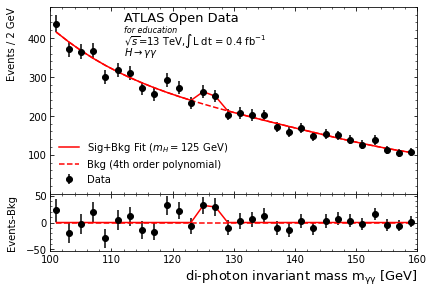

In [10]:
plot_data(data)

[Back to contents](#contents)

<a id='going_further'></a>

## What can you do to explore this analysis?

* Increase the fraction of data used in '[Lumi, fraction, file path](#fraction)'
* Use data_B, data_C and data_D in '[Samples](#samples)'
* Check how many events are being thrown away by each cut in '[Applying a cut](#applying_cut)'
* Add more cuts from the [Higgs discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0090) in '[Changing a cut](#changing_cut)' and '[Applying a cut](#applying_cut)'
* Find the reduced chi-squared for the fit in '[Plotting](#plotting)'
* Find the mean of the fitted Gaussian in '[Plotting](#plotting)'
* Find the width of the fitted Gaussian in '[Plotting](#plotting)'
* Try different initial guesses for the parameters of the fit in '[Plotting](#plotting)'
* Try different functions for the fit in '[Plotting](#plotting)'
* Your idea!

[Back to contents](#contents)